# Part I
## Handling and visualizing data

In this notebook we will download the luminosity data and we will discuss how to visualize them, how to compute secondary features from the modulation of the light sources. 

### Importing libraries
In this notebook we will be using:
 * `numpy` providing basic capabilities of numerical computation in Python
 * `pandas` adding to numpy a database-like access to data stored in a DataFrame data object
 * `matplotlib.pyplot` providing basic plotting capabilities

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

### Downloading the dataset

In [2]:
dataset_filename = "https://pandora.infn.it/public/806aa1/dl/exoTrain.csv"
df = pd.read_csv(dataset_filename)

### Exploring the dataset

Let's start by looking at the dataset to grasp some general information.

Visualizing the dataset in tabular form we observe that it has a first column representing the label:
 * 1: *the star is known to not have exoplanets*
 * 2: *the star is known to have exoplanets*
followed by 3197 columns representing the luminosity as a function of time (in intervals of 30 minutes).

In [3]:
df

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


The dataset is rather unbalanced as we can immediately visualize with a pie chart.

1    5050
2      37
Name: LABEL, dtype: int64


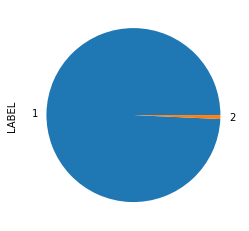

In [4]:
df.LABEL.value_counts().plot.pie()
print (df.LABEL.value_counts())

Building the histogram of the luminosities we clearly see that the luminosities spans over a very large range of values covering multiple orders of magnitude. 

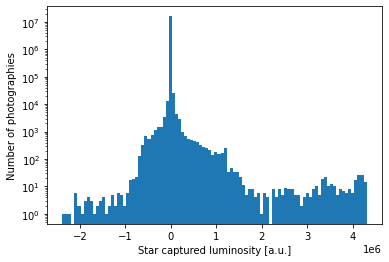

In [5]:
raw = df[df.columns[1:]].values
plt.hist(raw.flatten(), bins=100)
plt.yscale('log')
plt.xlabel("Star captured luminosity [a.u.]")
plt.ylabel("Number of photographies")
plt.show()

### Preprocessing
Since we are mostly interested in effects in the frequency domain, we can clean global luminosity effects interesting the whole evolution of a star. Here we are using our intuition that suggests that the fact a star is more bright should not correlate with the probability of having exoplanets (most likely it is simply closer to Earth...).

Then we remove the average luminosity of each row in our table, and divide by its standard deviation.
In data science jargon, this is named *standardization*.

In [6]:
data = (raw - raw.mean(axis=1, keepdims=True))/raw.std(axis=1, keepdims=True)

Drawing some preprocessed waveform, it is evident that some of the waveforms have luminosity structures at low frequency that can hardly correlate to exoplanets (though they may indicate binary stars or similar structures...).
For example, look at star #123.

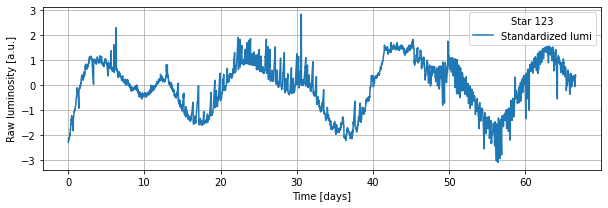

In [7]:
xAxis = np.arange(data.shape[1]) * 0.5 / 24
plt.figure(figsize=(10,3))
plt.plot(xAxis, data[123], label="Standardized lumi")
plt.grid()
plt.xlabel("Time [days]")
plt.ylabel("Raw luminosity [a.u.]")
plt.legend(title="Star 123")
plt.show()

Using [scipy](https://docs.scipy.org), we can easily define a digital filter to retrieve the low-frequency modulation and possibly subtract it from the signal.
Digital filtering in scipy is implemented through the [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) function, combined with a function defining the filter transform. For example, *butter* defines a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) mimicking an ideal passive electronic filter.

The first argument of the `butter` function is the order of the filter, the second one is the cutoff frequency.
Not that the frequency is expressed as a function of the Nyquist frequency to be independent of the actual sampling rate. 

In this problem the Nyquist frequency is 
$$
f_N = \frac{1}{2}\ \frac{1}{30 \cdot 60} = 2.8\times 10^{-4}\ \mathrm{Hz} = 1\, \mathrm{hour}^{-1}
$$

We design a filter with a cutoff frequency of $0.5\ \mathrm{day}^{-1}$ which roughly correspond to average everything happening within the same day (on Earth).

> **Feel free to play with the filter definition to see how the filter function changes modifying order and cutoff!**

In [8]:
from scipy.signal import butter, filtfilt

b, a = butter(4, 0.5/24)
filtered = filtfilt(b, a, data)

To visualize the effect of the filter we superpose the original and filtered version of the luminosity stream of star #123.

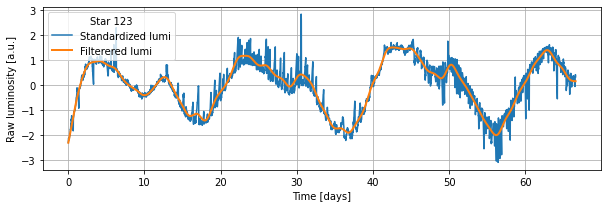

In [9]:
plt.figure(figsize=(10,3))
plt.plot(xAxis, data[123], label="Standardized lumi")
plt.plot(xAxis, filtered[123], label="Filterered lumi", linewidth=2)
plt.grid()
plt.xlabel("Time [days]")
plt.ylabel("Raw luminosity [a.u.]")
plt.legend(title="Star 123")
plt.show()

Subtracting the filtered component from the original waveform we obtain a noisy waveform that is easier to analyse programmatically.

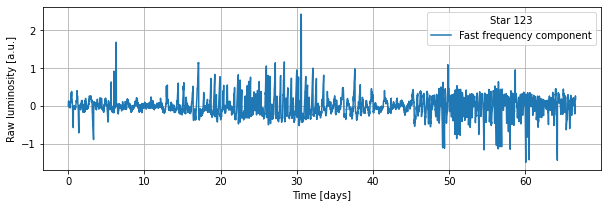

In [10]:
plt.figure(figsize=(10,3))
plt.plot(xAxis, data[123]-filtered[123], label="Fast frequency component")
plt.grid()
plt.xlabel("Time [days]")
plt.ylabel("Raw luminosity [a.u.]")
plt.legend(title="Star 123")
plt.show()

### Correcting experimental biases

The high frequency noise observed in the previous block may be due to experimenal differences in the sensitivity of the camera or on the exposure, rather than on real modifications of the star luminosity. If this is the case, we should see a correlation of the luminosity of most stars at the same acquisition time. 

To qualitatively test this hypotesis, we create figures in which the gray level corresponds to the luminosity of each star at a given instant. The human eye is rather good at noticing patterns and will tell us immediately whether this kind of correlation should be corrected for.

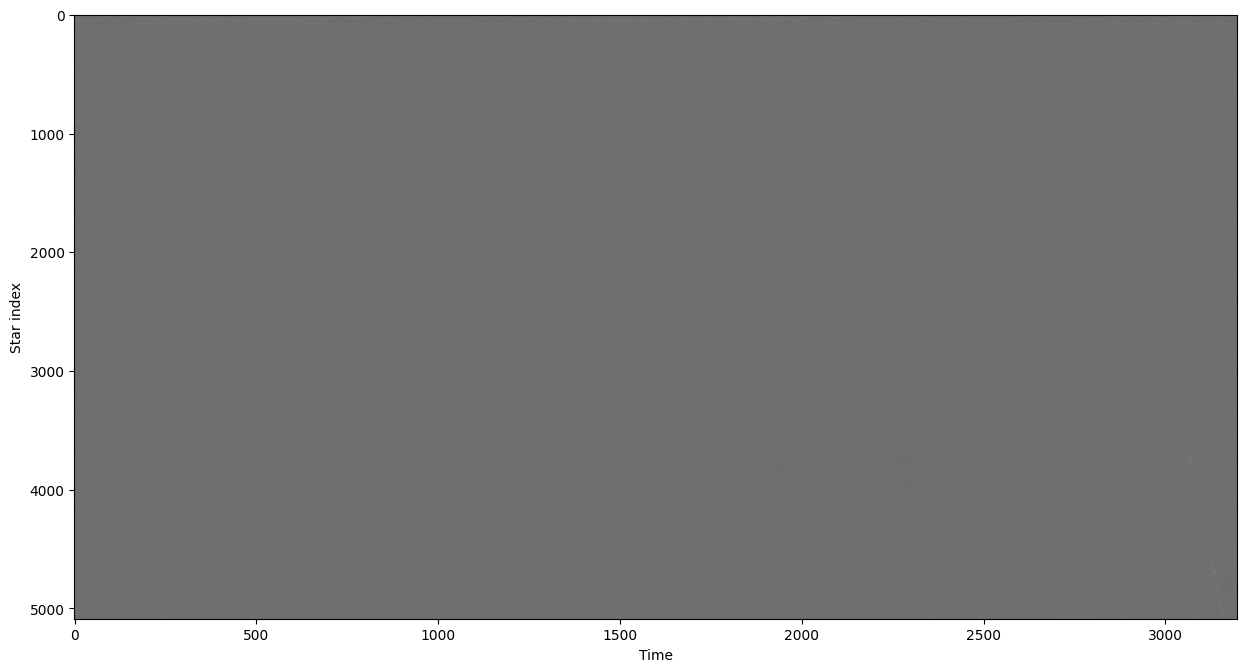

In [11]:
plt.figure(figsize=(15,8), dpi=100)
plt.imshow(data, aspect='auto', cmap='gray')
plt.xlabel("Time")
plt.ylabel("Star index")
plt.show()

Unfortunately the image appears completely uniform. We *know* that, even after standardization and filtering, our dataset is not constant everywhere. So what is happening? Let's draw a histogram of the standardized and filtered data. 

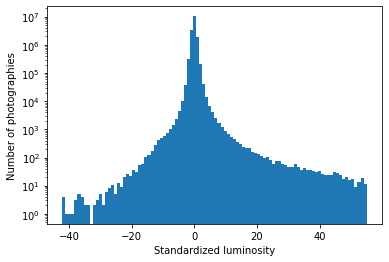

In [12]:
plt.hist((data - filtered).flatten(), bins=100)
plt.xlabel("Standardized luminosity")
plt.ylabel("Number of photographies")
plt.yscale('log')
plt.show()

Clearly, there are few pixels with a very high or very low value. To convert the pixel value into a gray scale, pyplot takes the minimum and the maximum of the values to be converted and maps them into black and white, respectively. In this case, however, the vast majority of the pixels is varying on a scale which is tremendously smaller than the difference between minimum and maximum. This makes the figure unreadable.

A possible solution is to discard the outlayers in order to resolve effects within the distribution core.

In practice, we clip the values of the normalized and filtered data
$$
f(x) = \left\{
\begin{array}{ll}
\ell & \mbox{where}\ x < \ell\\
h & \mbox{where}\ x > h\\
x & \mbox{elsewhere}
\end{array}
\right.
$$
where $\ell$ and $h$ are determined inverting the relation
$$
\int_{-\infty}^{\ell} p(L)\mathrm dL = \varepsilon \qquad \int_{h}^{+\infty} p(L)\mathrm dL = \varepsilon,
$$
where $p(L)$ represents the distribution of luminosity.

In practice, in Python it is very simple. The following function uses the functions `np.quantile` and `np.clip` to apply this transform, and then it creates the figure, taking $\varepsilon$ as an argument.


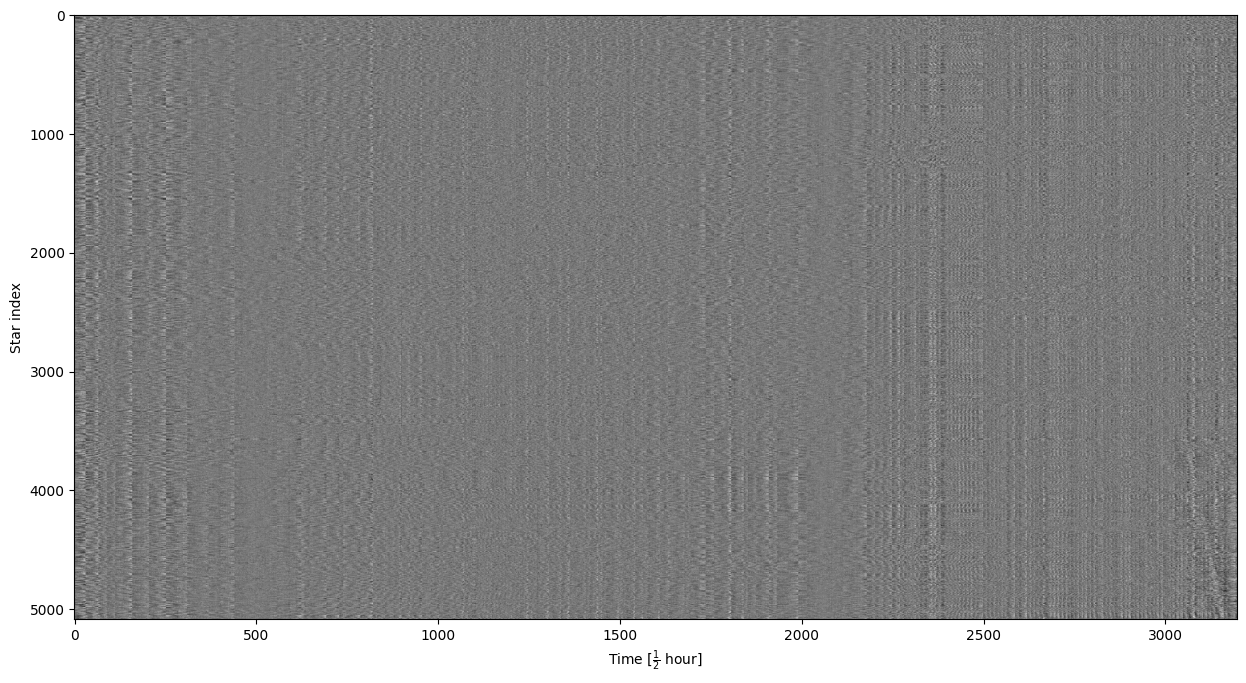

In [13]:
def build_figure(data, epsilon=None):
    plt.figure(figsize=(15,8), dpi=100)
    if epsilon is not None:
        low, high = np.quantile(data, [epsilon, 1-epsilon])
        data = np.clip(data, low, high)
    plt.imshow(data, aspect='auto', cmap='gray')
    plt.xlabel("Time [$\\frac{1}{2}$ hour]")
    plt.ylabel("Star index")

    plt.show()

build_figure(data - filtered, 1e-2)

### Exercise 1.1 - Final preprocessing ⏳
Use the functions discussed above to replace the definition of `prep_data` below, with a version preprocessed standardizing per time instant and then per star.


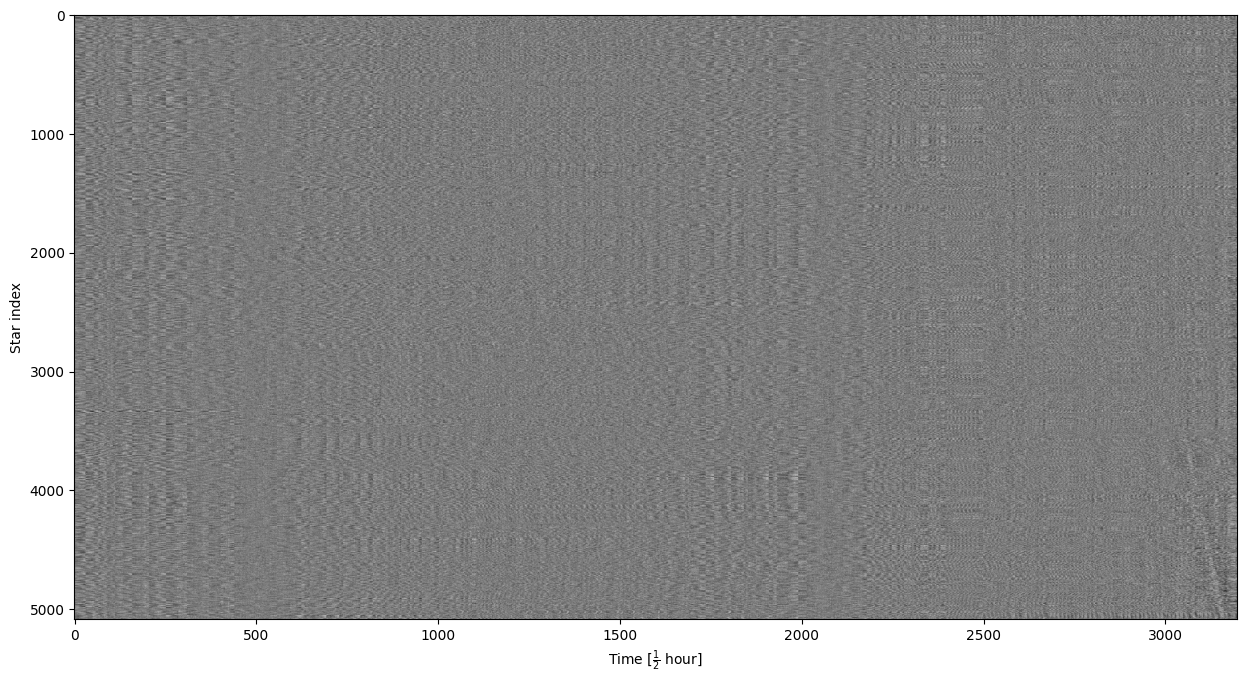

In [14]:
#prep_data = data-filtered
## Solution:
prep_data = ((data-filtered) - np.mean(data-filtered, axis=0, keepdims=True)) / np.std(data-filtered, axis=0, keepdims=True)
prep_data = (prep_data - prep_data.mean(axis=1, keepdims=True))/prep_data.std(axis=1, keepdims=True)
build_figure(prep_data, 1e-2)

## Visualization of the preprocessed waveforms to be classified

We combine in a unique figure the luminosity stream of several stars.
We highlight in *red* the waveforms corresponding to stars with exoplanets.

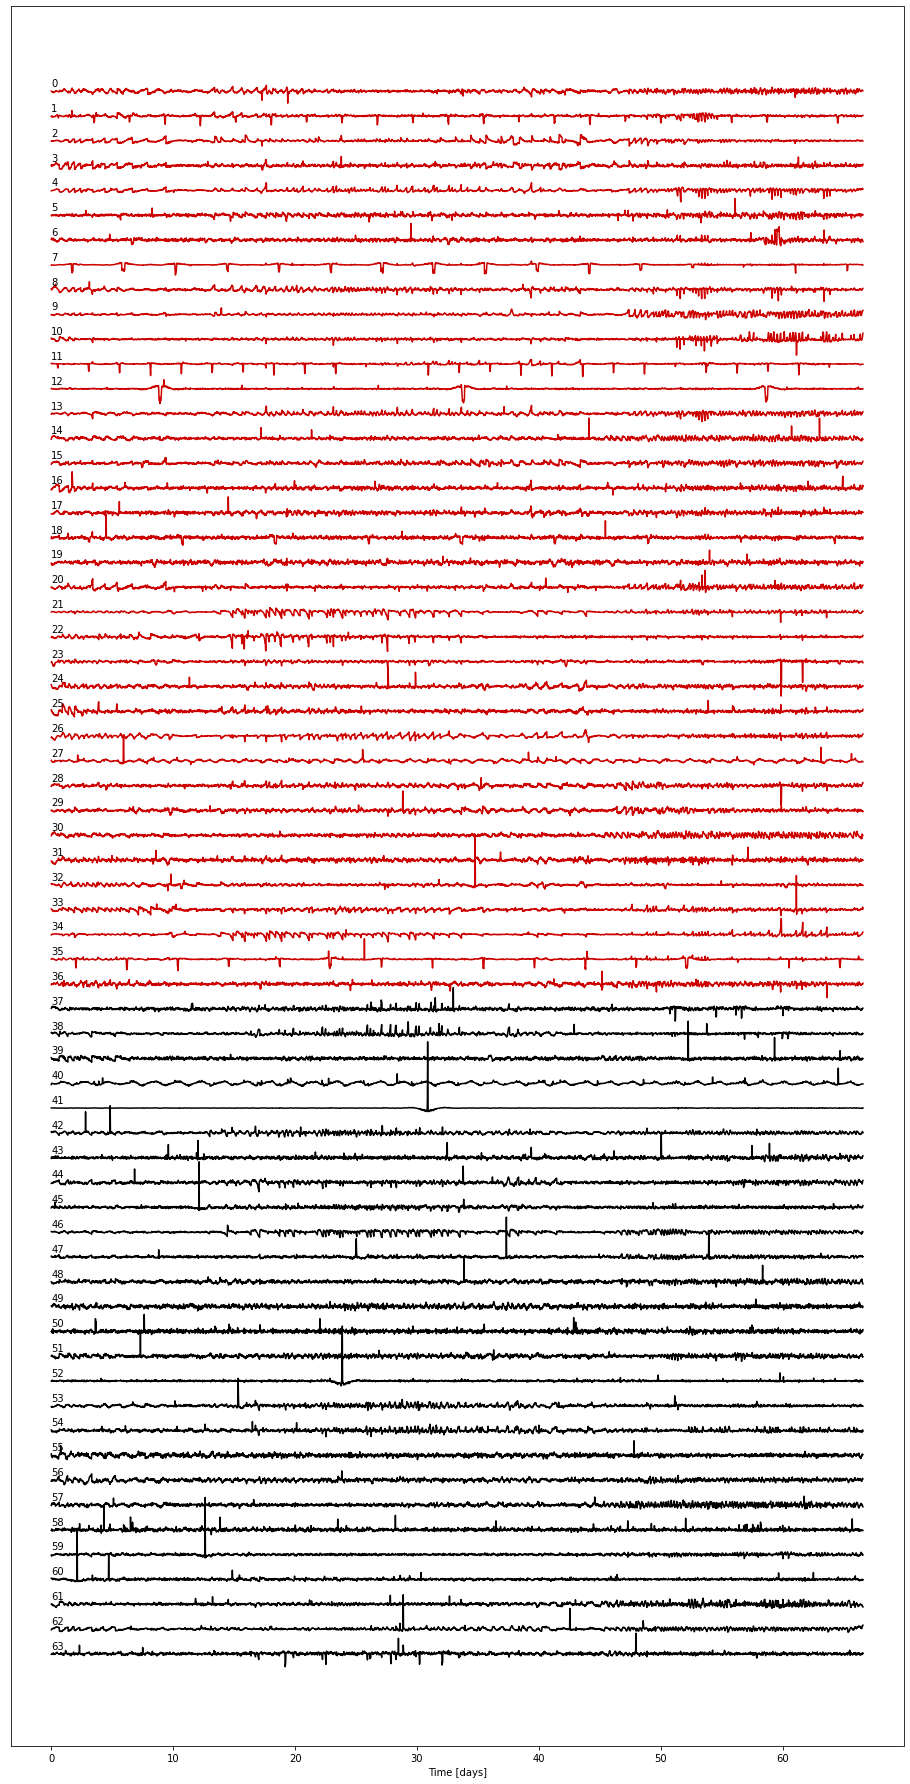

In [15]:
plt.figure(figsize=(16,32))

for star_id in range(64):
    plt.plot(xAxis, prep_data[star_id] - 20*star_id, color='#c00' if df.LABEL.values[star_id]==2 else 'black', alpha=1)
    plt.text(0, -20*star_id + 4, str(star_id))
plt.xlabel("Time [days]")
plt.yticks([])
plt.show()

# Exercises

### Exercise 1.2 - Slicing and Visualization ⏳
Consider stars #1 and #7 which have clear effects of exoplanets and try to zoom over the negative luminosity peaks.

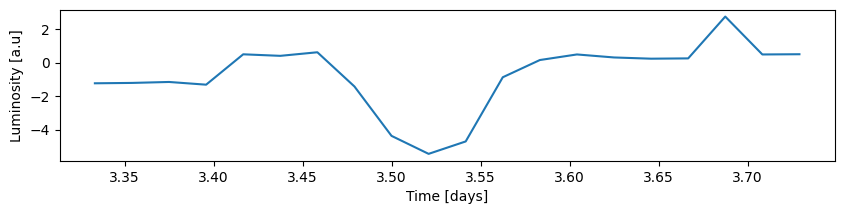

In [16]:
## Solution
plt.figure(figsize=(10,2), dpi=100)
low, high = 160, 180
plt.plot(xAxis[low:high], prep_data[1, low:high])
plt.xlabel("Time [days]")
plt.ylabel("Luminosity [a.u]")
plt.show()

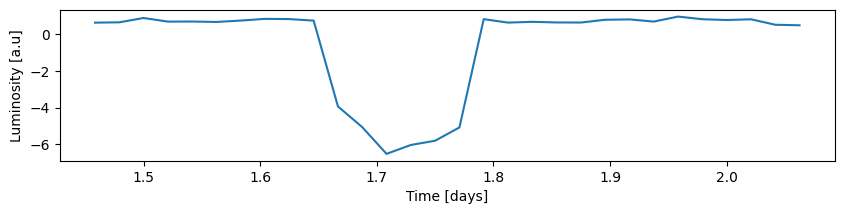

In [17]:
## Solution
plt.figure(figsize=(10,2), dpi=100)
low, high = 70, 100
plt.plot(xAxis[low:high], prep_data[7, low:high])
plt.xlabel("Time [days]")
plt.ylabel("Luminosity [a.u]")
plt.show()

### Exercise 1.3 - Bandpass filter ⏳⏳
Having a look to the documentation of `scipy.signal.butter` to define a bandpass filter that enhances the importance of the shadowing peaks. You can use the peaks highlighted in the previous exercise to visualize the effect of the bandpass filter.

Take the minimum of the filtered waveform as a discriminant variable between stars with and without exoplanets.

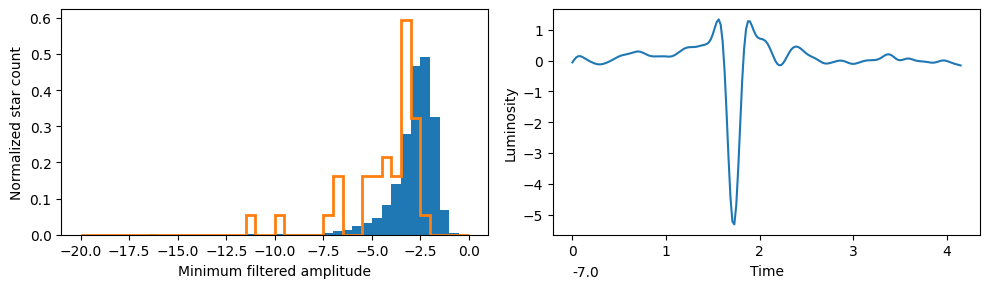

In [18]:
b, a = butter(3, [0.01, 0.2], btype='bandpass')
filtered = filtfilt(b, a, prep_data)

max_hf = np.min(filtered, axis=1)

plt.figure(figsize=(10,3), dpi=100)
plt.subplot(1,2,1)
bins = np.linspace(-20, 0, 41)
plt.hist(max_hf, bins=bins, density=True)
plt.hist(max_hf[df.LABEL==2], bins=bins, density=True, linewidth=2, histtype='step')
plt.xlabel("Minimum filtered amplitude")
plt.ylabel("Normalized star count")

plt.subplot(1,2,2)
plt.plot(xAxis[:200], filtered[7, :200])
plt.text(0, max_hf[7], f"{max_hf[7]:.1f}")
plt.ylabel("Luminosity")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

### Exercise 1.4 - Count threshold crossings ⏳⏳
Define a threshold at, for example, -2, and count the number of times the waveform crosses the threshold.

Crossing the threshold means sample $i$ is above threshold and sample $i+1$ is below.

> **Hint.** You can use `np.count_nonzero` applied to a boolean array to count the occurences of something.

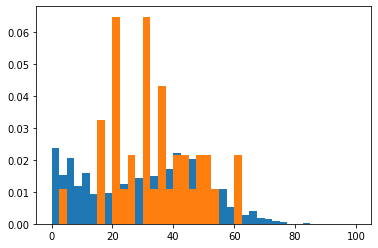

In [19]:
threshold = -2
crossings = np.count_nonzero((prep_data[:, :-1] < threshold) & (prep_data[:, 1:] > threshold), axis=1)

bins = np.linspace(0, 100, 41)
plt.hist(crossings, bins=bins, density=True)
plt.hist(crossings[df.LABEL==2], bins=bins, density=True)

plt.show()

### Exercise 1.4 - Count threshold crossings, with Time Below Threshold ⏳⏳⏳

Extend the previous exercise by requiring that the waveform remains low by a given number of samples. 

> **Hint.** Consider using `np.all` for requiring that all samples in a sequence satisfy the requirement of being below the threshold. 


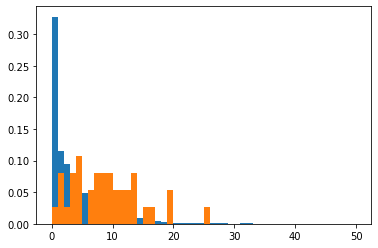

In [20]:
threshold = -2
length = 3
crossings = np.count_nonzero(
    np.all([prep_data[:, (i):-(length-i)] < threshold for i in range(length)], axis=0) & (prep_data[:, length:] > threshold), axis=1)

bins = np.linspace(0, 50, 51)
plt.hist(crossings, bins=bins, density=True)
plt.hist(crossings[df.LABEL==2], bins=bins, density=True)

plt.show()

### Exercise 1.5 - Exploit periodicity with your own C algorithm ⏳⏳⏳⏳

Take a look at [this notebook](../boilerplates/CfromPython.ipynb).
It provides an example of wrapping C code to a Python function.

Starting from that example, try to implement the following algorithm.

Given the brightness $b$ at time $t \in \{t_0, t_1, ..., t_n\}$, $b(t)$ we define an estimator of the period as
$$
\hat T = \mathop{\rm argmin}_{i\, >\, T_0}\left[ \mathop{\rm min}_{j < i} \left( \sum_{k \in \{j, j+i, j + 2i...\}} \frac{b(t_k)}{\left[\mathrm{floor}\left(\frac{n}{i}\right)\right]^{\alpha}} \right)\right]
$$

$T_0$ is the minimal reasonable period (works decently with $T_0 \sim 50 \,\mathrm{hours}$, or $T_0 = 100$ if expressed in 30-minute time steps.

$\alpha$ is a constant that is used to enhance the importance of low frequency periodicity. Should be tuned for best discrimination power in the range $\alpha \in [0,  1]$. 

In [21]:
print("""
#include <math.h>

extern "C"
int best_matching_period (int n, double alpha, double* lumi)
{
    int i, j, k;
    int best_period; 
    double min_loss = 9999.;
    double loss;
    
    for (i = 100; i < n/2; ++i)
        for (j = 1; j < i; ++j)
        {
            loss = 0;
            for (k = j; k < n; k+= i)
                loss += lumi[k];
        
            loss /= pow(n/i, alpha);
    
            if (loss < min_loss)
            {
                min_loss = loss;
                best_period = i;
            }
        }
    
    return best_period;
}
""", file=open('src.C', 'w'))

import random
SO_NAME = f"./exoplanets.{random.randint(0,0xffff)}.so"
!gcc --shared -fPIC src.C -o {SO_NAME}

In [22]:
import ctypes
exolib = ctypes.CDLL(SO_NAME)
exolib.best_matching_period.restype = ctypes.c_int
exolib.best_matching_period.argtypes = [ctypes.c_int, ctypes.c_double, np.ctypeslib.ndpointer(dtype=np.float64)]

In [23]:
period = []
from tqdm import tqdm
for row in tqdm(prep_data):
    period.append(exolib.best_matching_period(len(row), 0.5, row))
period = np.array(period)

100%|██████████| 5087/5087 [06:53<00:00, 12.32it/s]


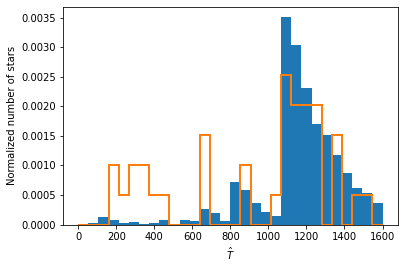

In [24]:
bins = np.linspace(0, 1600, 31)
plt.hist(period, bins=bins, density=True)
plt.hist(period[df.LABEL.values == 2], bins=bins, density=True, histtype='step', linewidth=2)
plt.xlabel("$\hat T$")
plt.ylabel("Normalized number of stars")
plt.show()

### Exercise 1.6 - Parallelize the execution on multiple threads ⏳⏳

Take a look to `ThreadPool`(https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool) to parallelize on multiple thread the execution your C algorithm.

> **Note.** You might be tempted to try using `multiprocessing.Pool` instead, DO NOT TRY! 
>
> Forking this application with dependencies on the loaded C library results into indefinite behaviour (ahh... good old C!). 
>
> Otimistically, it would silently crash the Python kernel behind the Jupyter notebook server.

In [37]:
from multiprocessing.pool import ThreadPool
pool = ThreadPool(32)
def get_period(row):
    return exolib.best_matching_period(len(row), 0.5, row);

period = np.array(pool.map(get_period , list(prep_data)))

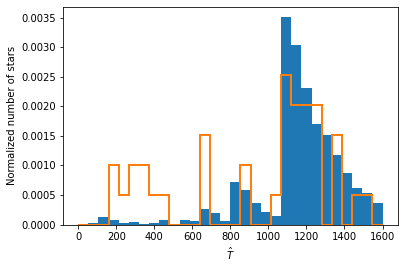

In [38]:
bins = np.linspace(0, 1600, 31)
plt.hist(period, bins=bins, density=True)
plt.hist(period[df.LABEL.values == 2], bins=bins, density=True, histtype='step', linewidth=2)
plt.xlabel("$\hat T$")
plt.ylabel("Normalized number of stars")
plt.show()

### Exercise 1.7 - Return also the minimum value (not only its index)
So far we have returned a single value: the period estimator obtained with the minimization described above.
In this exercise you are invited to modify the code to return two values.

> **Hint.** A customary technique to return multiple values from a C function is to pass buffer arrays as arguments and filling them from inside the function. Since the arrays are always passed per-reference, the array allocated by the calling function will also be updated. You can use the same approach, defining numpy arrays as buffer in Python code and let them to be filled by the C function with whatever values you wish to retrieve.

In [43]:
print("""
#include <math.h>

extern "C"
void best_matching_period (int n, double alpha, double* lumi, int *best_period_out, double *loss_out)
{
    int i, j, k;
    int best_period; 
    double min_loss = 9999.;
    double loss;
    
    for (i = 100; i < n/2; ++i)
        for (j = 1; j < i; ++j)
        {
            loss = 0;
            for (k = j; k < n; k+= i)
                loss += lumi[k];
        
            loss /= pow(n/i, alpha);
    
            if (loss < min_loss)
            {
                min_loss = loss;
                best_period = i;
            }
        }
    
    *best_period_out = best_period;
    *loss_out = min_loss;
}
""", file=open('src.C', 'w'))

import random
SO_NAME = f"./exoplanets.{random.randint(0,0xffff)}.so"
!gcc --shared -fPIC src.C -o {SO_NAME}

In [44]:
exolib2 = ctypes.CDLL(SO_NAME)
exolib2.best_matching_period.argtypes = [
    ctypes.c_int, 
    ctypes.c_double, 
    np.ctypeslib.ndpointer(dtype=np.float64),
    np.ctypeslib.ndpointer(dtype=np.int32),    
    np.ctypeslib.ndpointer(dtype=np.float64)
]

In [64]:
from multiprocessing.pool import ThreadPool
pool = ThreadPool(32)
def get_period(row):
    buff_loss = np.array(0., dtype=np.float64)
    buff_period = np.array(0, dtype=np.int32)
    exolib2.best_matching_period(len(row), 0.4, row, buff_period, buff_loss);
    return (int(buff_period), float(buff_loss))

period, loss = np.array(pool.map(get_period , list(prep_data))).T

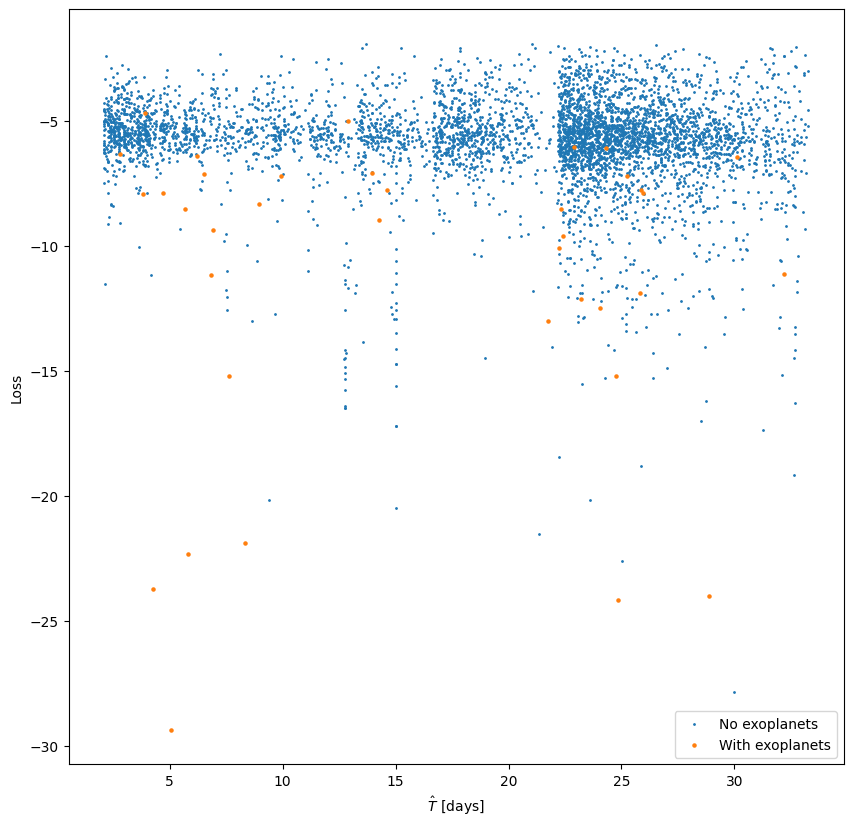

In [65]:
plt.figure(figsize=(10,10), dpi=100)
plt.scatter(period[df.LABEL.values == 1]/48, loss[df.LABEL.values == 1], s=1, label="No exoplanets")
plt.scatter(period[df.LABEL.values == 2]/48, loss[df.LABEL.values == 2], s=5, label="With exoplanets")
plt.xlabel("$\hat T$ [days]")
plt.ylabel("Loss")
plt.legend()
plt.show()